In [1]:
#!gdown --id 1HV6zeS_pqNrDOfHr3A7UvJKnyzy5u4K1
#!gdown --id 1S6Eg67vDSUSx6usqnAYgHCR2oEYeNvmI

In [2]:
#!nvidia-smi

In [3]:
#import tensorflow as tf

#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
import pandas as pd
import re
import numpy as np
import itertools
import collections
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud

import nltk
nltk.download('treebank')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

import gensim
from gensim.models import KeyedVectors, Word2Vec, FastText

import tensorflow as tf
import unicodedata

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\phvpa\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phvpa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phvpa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\phvpa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\phvpa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
C:\Users\phvpa\anaconda3\envs\NLP\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, b

In [6]:
#ls

In [7]:
#train_df = pd.read_csv("Mal_sentiment_full_train.tsv", header=None, sep='\t')
train_df = pd.read_csv("Mal_sentiment_full_train.tsv", sep='\t')
print(len(train_df))

#test_df = pd.read_csv("Mal_sentiment_full_dev.tsv", header=None, sep='\t')
valid_df = pd.read_csv("Mal_sentiment_full_dev.tsv", sep='\t')
print(len(valid_df))

test_df = pd.read_csv("Mal_sentiment_full_test_withoutlabels.tsv", sep='\t')
len(test_df)

15888
1766


1962

In [8]:
test_df

,id,text
0,Mal_1,Teaserinu kurach samayamkoodi mathram. Cant wa...
1,Mal_2,അപ്പോൾ കഥയുടെ റൂട്ട് മാറിയല്ലോ...
2,Mal_3,മൂത്തോൻ ട്രൈലെർ Trending List വരാത്തത് എന്താ ?
3,Mal_4,Nowadays 944k views is considered as 1M views ...
4,Mal_5,Maass.trailer ennu paranja ithaanU makkale.......
...,...,...
1957,Mal_1958,Expression വച്ചു നോക്കുമ്പോൾ മൂക്കുത്തി കട്ടത്...
1958,Mal_1959,എനിക്ക് ഒരു 100 like തരുമോ
1959,Mal_1960,Nannayi onnu poliyunna lakshnm unde...Thrill m...
1960,Mal_1961,Athikam eduthu kayatti vekkenda....direction k...


In [9]:
print(test_df['text'][279])
print(test_df['text'][516])
print(test_df['text'][546])
print(test_df['text'][555])
print(test_df['text'][559])
print(test_df['text'][570])
print(test_df['text'][825])
print(test_df['text'][838])
print(test_df['text'][860])
print(test_df['text'][890])
print(test_df['text'][1234])

Oru pani-palal manakunnu again Mr. JR :/
Ende ponno 68 vayasaya oraluda body thanneyano ith.... 🤩.. NAMICHU PONNIKKAAAA
FDFS.. trailer kandu ithu vareyum njanithu paranjittilla..🤩🤩
Degraders step BacK 🤫...  മമ്മൂക്ക
ഈ പാട്ട് ഡിസ്‌ലൈക് ചെയ്തവരുടെ വീട്ടുകാരെ സമ്മതിക്കണം .....BIG SALUTE
ഇത് ഏത് ഭാഷ ശിവനെ ഏത് ജില്ല 🤔🤔🤔🤔🤔🤔🤔
ഇതൊക്കെ മമ്മുക്ക പറഞ്ഞാൽ പൊളിക്കും 🤩 🤩 🤩
1:08 ST PIUS X KUTTIKANAM        *UYIR*🤩🤩🤩
Ente ponno..... Heavy.... BGM... Ikka pinne parayanilla....2 looks kidilosky 🤩🤩 Overall kidukkachi aahn Mone...
Song dislike adicha 90% perum phycho singles akum🤩
അഭ്യർത്ഥന ____________________ മാമാങ്കം പലകുറി കൊണ്ടാടും  എന്ന ഗാനം ടൈറ്റിൽ സോങ്ങ് ആയി ഉൾപ്പെടുത്താമോ....  Album :vasantha geethangal Singer: K J YESUDAS


In [10]:
train_df['text'][0]

'Sunny chechi fans evide like adichu power kaniku🤣🤣'

In [11]:
train_df

,text,category
0,Sunny chechi fans evide like adichu power kani...,unknown_state
1,Angane july month ile ende aadyathe leave njan...,Positive
2,ഏട്ടന്റെ പുതിയ പടത്തിനു വേണ്ടി കാത്തിരിക്കുന്ന...,unknown_state
3,ഇനി ലാലേട്ടന്റെ വേട്ട തുടങ്ങാൻ പോകുന്നു..........,Positive
4,Trailer powli oru raksha illa . Pakshea padam ...,Positive
...,...,...
15883,Minimum 10 thavana kandavar maathram like adi,unknown_state
15884,Please cinema kaannaaan kothi aakunnu onnu rel...,Positive
15885,USA ok.. India No... Sadhacharam,unknown_state
15886,nama hero december 12 wait & see mamamaga mah...,Positive


In [12]:
valid_df

,text,category
0,Mammooka ninghal mass aa pwoli item,Positive
1,Waiting for Malayalam movie For Tamil paiyan,not-malayalam
2,ദളപതി ഫാൻസിന്റെ വക ഒരു ഒന്നൊന്നര വിജയാശംസകൾ...,Positive
3,#Trailer pwolichuuuu ഓണത്തിന് വന്നങ്ങു തകർത്തേ...,Positive
4,Mammoookkaaaa polichadukkiii katta waiting nv 21,Positive
...,...,...
1761,Aa ചിരി uff എന്റെ പൊന്നോ ഇക്ക vere ലെവൽ,Positive
1762,Katta katta katta katta waiting....cant wait man,Positive
1763,Arjun reddy bgm poole thonniyathu enniku mathr...,unknown_state
1764,Fahad ikka ithilum polikum en urappayi,Positive


In [13]:
valid_df['text']

0                     Mammooka ninghal mass aa pwoli item
1           Waiting for Malayalam movie  For Tamil paiyan
2          ദളപതി ഫാൻസിന്റെ വക ഒരു ഒന്നൊന്നര വിജയാശംസകൾ...
3       #Trailer pwolichuuuu ഓണത്തിന് വന്നങ്ങു തകർത്തേ...
4        Mammoookkaaaa polichadukkiii katta waiting nv 21
                              ...                        
1761              Aa ചിരി uff എന്റെ പൊന്നോ ഇക്ക vere ലെവൽ
1762     Katta katta katta katta waiting....cant wait man
1763    Arjun reddy bgm poole thonniyathu enniku mathr...
1764               Fahad ikka ithilum polikum en urappayi
1765    Njan veendum kanan vannu 100 pravashyam enkilu...
Name: text, Length: 1766, dtype: object

In [14]:
#removing all the emoji from the given data

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


for i in range(len(train_df)):
    temp1 = deEmojify(train_df['text'][i])
    train_df['text'][i] = temp1

for j in range(len(valid_df)):
    temp2 = deEmojify(valid_df['text'][j])
    valid_df['text'][j] = temp2

for k in range(len(test_df)):
    temp3 = deEmojify(test_df['text'][k])
    test_df['text'][k]=temp3

In [15]:
print(test_df['text'][516])
print(test_df['text'][546])
print(test_df['text'][555])
print(test_df['text'][559])
print(test_df['text'][570])
print(test_df['text'][825])
print(test_df['text'][838])
print(test_df['text'][860])
print(test_df['text'][890])
print(test_df['text'][1234])

Ende ponno 68 vayasaya oraluda body thanneyano ith.... .. NAMICHU PONNIKKAAAA
FDFS.. trailer kandu ithu vareyum njanithu paranjittilla..
Degraders step BacK ...  മമ്മൂക്ക
ഈ പാട്ട് ഡിസ്‌ലൈക് ചെയ്തവരുടെ വീട്ടുകാരെ സമ്മതിക്കണം .....BIG SALUTE
ഇത് ഏത് ഭാഷ ശിവനെ ഏത് ജില്ല 
ഇതൊക്കെ മമ്മുക്ക പറഞ്ഞാൽ പൊളിക്കും   
1:08 ST PIUS X KUTTIKANAM        *UYIR*
Ente ponno..... Heavy.... BGM... Ikka pinne parayanilla....2 looks kidilosky  Overall kidukkachi aahn Mone...
Song dislike adicha 90% perum phycho singles akum
അഭ്യർത്ഥന ____________________ മാമാങ്കം പലകുറി കൊണ്ടാടും  എന്ന ഗാനം ടൈറ്റിൽ സോങ്ങ് ആയി ഉൾപ്പെടുത്താമോ....  Album :vasantha geethangal Singer: K J YESUDAS


In [16]:
def preprocess_data(text):
  user_name = '@[A-Za-z0-9]+' # Pattern for matching the user names in the tweet
  has_tag = '#[A-Za-z0-9]+' # Pattern for matching the hasgtags in the tweer
  url = 'https?:\/\/[A-Za-z0-9\.\/\-]+' # Pattern for matching the URLs in the tweet
  #emoji_pattern = r'/[x{1F600}-x{1F64F}]/u'
  
  x = text.lower()  # Lower casing all the characters
  x = re.sub(user_name, '', x) # Replace the username with an empty characrer
  x = re.sub(has_tag,'',x) # Replace the hashtags with an empty characrer
  x = re.sub(url, '', x) # Replace the URLs with an empty characrer
  #x = re.sub(emoji_pattern, '', x)
  x = x.translate(str.maketrans('', '', string.punctuation)) # Replace all the characters except alphabets and digits from the tweet

  return x

In [17]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe
valid_df['text'] = valid_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe
test_df['text'] = test_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe

In [18]:
print(test_df['text'][279])
print(test_df['text'][516])
print(test_df['text'][546])
print(test_df['text'][555])
print(test_df['text'][559])
print(test_df['text'][570])
print(test_df['text'][825])
print(test_df['text'][838])
print(test_df['text'][860])
print(test_df['text'][890])
print(test_df['text'][1234])

oru panipalal manakunnu again mr jr 
ende ponno 68 vayasaya oraluda body thanneyano ith  namichu ponnikkaaaa
fdfs trailer kandu ithu vareyum njanithu paranjittilla
degraders step back   മമ്മൂക്ക
ഈ പാട്ട് ഡിസ്‌ലൈക് ചെയ്തവരുടെ വീട്ടുകാരെ സമ്മതിക്കണം big salute
ഇത് ഏത് ഭാഷ ശിവനെ ഏത് ജില്ല 
ഇതൊക്കെ മമ്മുക്ക പറഞ്ഞാൽ പൊളിക്കും   
108 st pius x kuttikanam        uyir
ente ponno heavy bgm ikka pinne parayanilla2 looks kidilosky  overall kidukkachi aahn mone
song dislike adicha 90 perum phycho singles akum
അഭ്യർത്ഥന  മാമാങ്കം പലകുറി കൊണ്ടാടും  എന്ന ഗാനം ടൈറ്റിൽ സോങ്ങ് ആയി ഉൾപ്പെടുത്താമോ  album vasantha geethangal singer k j yesudas


In [19]:
valid_df['text'][0]

'mammooka ninghal mass aa pwoli item'

In [20]:
print(train_df)
print()
#print(valid_df.head())
#print()
print(valid_df)
print()
print(test_df)

                                                    text        category
0       sunny chechi fans evide like adichu power kaniku   unknown_state
1      angane july month ile ende aadyathe leave njan...        Positive
2      ഏട്ടന്റെ പുതിയ പടത്തിനു വേണ്ടി കാത്തിരിക്കുന്ന...   unknown_state
3      ഇനി ലാലേട്ടന്റെ വേട്ട തുടങ്ങാൻ പോകുന്നു മുൻ കാ...        Positive
4      trailer powli oru raksha illa  pakshea padam i...        Positive
...                                                  ...             ...
15883      minimum 10 thavana kandavar maathram like adi   unknown_state
15884  please cinema kaannaaan kothi aakunnu onnu rel...        Positive
15885                        usa ok india no sadhacharam   unknown_state
15886  nama hero december 12 wait  see  mamamaga maha...        Positive
15887  madhuraraja 1 hour 40 k likes  lucifer 1 min 4...  Mixed_feelings

[15888 rows x 2 columns]

                                                   text       category
0                   mammoo

In [21]:
train_text = train_df['text'].tolist()
valid_text = valid_df['text'].tolist()
test_text = test_df['text'].tolist()

train_label = train_df['category'].tolist()
valid_label = valid_df['category'].tolist()


In [22]:
test_text

['teaserinu kurach samayamkoodi mathram cant wait',
 'അപ്പോൾ കഥയുടെ  റൂട്ട് മാറിയല്ലോ',
 'മൂത്തോൻ ട്രൈലെർ trending list വരാത്തത് എന്താ ',
 'nowadays 944k views is considered as 1m views in kerala',
 'maasstrailer ennu paranja ithaanu makkalekatta waiting for ',
 'ethu kandappol kgf orma vannathu enikku matram ano ',
 'vere level  onnum parayan ella',
 'idvere vere chilar parannadaaannn muruga nee theernnada ennn ini nangal mammookka fans sherikkum parayunnnu murugaaa nee theernnada ikka love',
 'റിലീസ് ചെയ്ത അന്ന് തന്നെ പടം കാണാൻ ബോണി പറഞ്ഞു',
 'lalettanu thulayam malayalam film industry yil latten mathram',
 'chankurappulla ikka fans vaa 21 nu charithram kurikkum',
 'മലയാളത്തിലെ ഏറ്റവും മാസ്സ് കഥാപാത്രം ആയിരിക്കും ഇത്',
 'പാടുമ്പോൾ ഹിന്ദിക്കാരി ആയ പാവം ആ ശ്രേയ വല്ലോം അറിഞ്ഞോ ഈ പാട്ടിന്റെ ഗതി കഷ്ടം',
 'മമ്മൂക്കയെ കാണാത്തതുകൊണ്ട് ആരും വിഷമിക്കേണ്ട മമ്മൂക്ക മൂക്കുത്തി കണ്ടു പിടിക്കാൻ പോയിരിക്കുകയാണ് കണ്ടു പിടിച്ച ഉടനെ വരുന്നതായിരിക്കും',
 'ഉണ്ണി മുകുന്ദന്റെ നോട്ടം കണ്ടാലറിയ മൂക്കുത്തി എട

In [23]:
class_names = list(set(train_label))
class_names

['Mixed_feelings', 'unknown_state', 'Positive', 'Negative', 'not-malayalam']

In [24]:
class_dist = Counter(train_label)
class_dist

Counter({'unknown_state': 5279,
         'Positive': 6421,
         'Negative': 2105,
         'Mixed_feelings': 926,
         'not-malayalam': 1157})

In [25]:
le = LabelEncoder()

train_label = le.fit_transform(train_label)
train_label

array([4, 2, 4, ..., 4, 2, 0], dtype=int64)

In [26]:
valid_label = le.fit_transform(valid_label)
valid_label

array([2, 3, 2, ..., 4, 2, 2], dtype=int64)

In [27]:
le.inverse_transform([0,1,2,3,4])

array(['Mixed_feelings', 'Negative', 'Positive', 'not-malayalam',
       'unknown_state'], dtype='<U14')

In [28]:
class_weight = {0:sum(class_dist.values())/class_dist[le.inverse_transform([0])[0]],
                1:sum(class_dist.values())/class_dist[le.inverse_transform([1])[0]],
                2:sum(class_dist.values())/class_dist[le.inverse_transform([2])[0]],
                3:sum(class_dist.values())/class_dist[le.inverse_transform([3])[0]],
                4:sum(class_dist.values())/class_dist[le.inverse_transform([4])[0]]}

class_weight

{0: 17.15766738660907,
 1: 7.547743467933492,
 2: 2.4743809375486685,
 3: 13.732065687121867,
 4: 3.009660920628907}

In [29]:
training_labels = tf.keras.utils.to_categorical(train_label)
validation_labels = tf.keras.utils.to_categorical(valid_label)

In [30]:
words_in_train = [sent.split() for sent in train_text] # Splitting the tweet into tokens
words_in_train[0:5]

[['sunny', 'chechi', 'fans', 'evide', 'like', 'adichu', 'power', 'kaniku'],
 ['angane',
  'july',
  'month',
  'ile',
  'ende',
  'aadyathe',
  'leave',
  'njan',
  'angu',
  'edukuva',
  'july',
  '5',
  'nu'],
 ['ഏട്ടന്റെ',
  'പുതിയ',
  'പടത്തിനു',
  'വേണ്ടി',
  'കാത്തിരിക്കുന്നവർ',
  'ലൈക്\u200c',
  'ബട്ടൺ',
  'അടിച്ചു',
  'പോളിക്കോ'],
 ['ഇനി',
  'ലാലേട്ടന്റെ',
  'വേട്ട',
  'തുടങ്ങാൻ',
  'പോകുന്നു',
  'മുൻ',
  'കാല',
  'collection',
  'recordukal',
  'ഭേതിച്ചിരിക്കും'],
 ['trailer',
  'powli',
  'oru',
  'raksha',
  'illa',
  'pakshea',
  'padam',
  'irangattea',
  'veruthea',
  'over',
  'degrade',
  'venda',
  'padam',
  'irangittu',
  'paraya']]

In [31]:
words_in_valid = [sent.split() for sent in valid_text] # Splitting the tweet into tokens
words_in_valid[0:5]

[['mammooka', 'ninghal', 'mass', 'aa', 'pwoli', 'item'],
 ['waiting', 'for', 'malayalam', 'movie', 'for', 'tamil', 'paiyan'],
 ['ദളപതി', 'ഫാൻസിന്റെ', 'വക', 'ഒരു', 'ഒന്നൊന്നര', 'വിജയാശംസകൾ'],
 ['pwolichuuuu', 'ഓണത്തിന്', 'വന്നങ്ങു', 'തകർത്തേക്ക്'],
 ['mammoookkaaaa', 'polichadukkiii', 'katta', 'waiting', 'nv', '21']]

In [32]:
words_in_test = [sent.split() for sent in test_text] # Splitting the tweet into tokens
words_in_test[0:5]

[['teaserinu', 'kurach', 'samayamkoodi', 'mathram', 'cant', 'wait'],
 ['അപ്പോൾ', 'കഥയുടെ', 'റൂട്ട്', 'മാറിയല്ലോ'],
 ['മൂത്തോൻ', 'ട്രൈലെർ', 'trending', 'list', 'വരാത്തത്', 'എന്താ'],
 ['nowadays',
  '944k',
  'views',
  'is',
  'considered',
  'as',
  '1m',
  'views',
  'in',
  'kerala'],
 ['maasstrailer',
  'ennu',
  'paranja',
  'ithaanu',
  'makkalekatta',
  'waiting',
  'for']]

In [33]:
all_words_train = list(itertools.chain(*words_in_train)) # Making a flatlist of all the words in the corpus
all_words_train[0:10]

['sunny',
 'chechi',
 'fans',
 'evide',
 'like',
 'adichu',
 'power',
 'kaniku',
 'angane',
 'july']

In [34]:
all_words_valid = list(itertools.chain(*words_in_valid)) # Making a flatlist of all the words in the corpus
all_words_valid[0:10]

['mammooka',
 'ninghal',
 'mass',
 'aa',
 'pwoli',
 'item',
 'waiting',
 'for',
 'malayalam',
 'movie']

In [35]:
all_words_test = list(itertools.chain(*words_in_test)) # Making a flatlist of all the words in the corpus
all_words_test[0:10]

['teaserinu',
 'kurach',
 'samayamkoodi',
 'mathram',
 'cant',
 'wait',
 'അപ്പോൾ',
 'കഥയുടെ',
 'റൂട്ട്',
 'മാറിയല്ലോ']

In [36]:
word_counts_train = collections.Counter(all_words_train)  # Computing the number of occurrence of all the words in the corpus
word_counts_train.most_common(15)

[('like', 1591),
 ('oru', 1415),
 ('ഒരു', 1378),
 ('trailer', 1179),
 ('ഈ', 1032),
 ('padam', 778),
 ('fans', 686),
 ('ee', 602),
 ('പടം', 598),
 ('ikka', 580),
 ('ഇത്', 515),
 ('mass', 513),
 ('movie', 453),
 ('ആണ്', 447),
 ('waiting', 447)]

In [37]:
word_counts_valid = collections.Counter(all_words_valid)  # Computing the number of occurrence of all the words in the corpus
word_counts_valid.most_common(15)

[('ഒരു', 187),
 ('like', 166),
 ('oru', 165),
 ('ഈ', 125),
 ('trailer', 108),
 ('മൂക്കുത്തി', 90),
 ('ikka', 76),
 ('padam', 67),
 ('ee', 64),
 ('fans', 64),
 ('പടം', 63),
 ('movie', 60),
 ('waiting', 55),
 ('ഇത്', 54),
 ('mass', 48)]

In [38]:
word_counts_test = collections.Counter(all_words_test)  # Computing the number of occurrence of all the words in the corpus
word_counts_test.most_common(15)

[('ഒരു', 205),
 ('like', 202),
 ('oru', 181),
 ('trailer', 152),
 ('ഈ', 121),
 ('padam', 99),
 ('ikka', 84),
 ('fans', 80),
 ('movie', 74),
 ('ee', 70),
 ('മൂക്കുത്തി', 62),
 ('mass', 62),
 ('പടം', 61),
 ('എന്ന്', 61),
 ('ആണ്', 61)]

In [39]:
# Creating a dataframe with words and corresponding frequency
words_with_counts_train = pd.DataFrame(word_counts_train.most_common(len(all_words_train)), columns=['words', 'count']) 
print(words_with_counts_train.head())

     words  count
0     like   1591
1      oru   1415
2      ഒരു   1378
3  trailer   1179
4        ഈ   1032


In [40]:
# Creating a dataframe with words and corresponding frequency
words_with_counts_valid = pd.DataFrame(word_counts_valid.most_common(len(all_words_valid)), columns=['words', 'count']) 
print(words_with_counts_valid.head())

     words  count
0      ഒരു    187
1     like    166
2      oru    165
3        ഈ    125
4  trailer    108


In [41]:
# Creating a dataframe with words and corresponding frequency
words_with_counts_test = pd.DataFrame(word_counts_test.most_common(len(all_words_test)), columns=['words', 'count']) 
print(words_with_counts_test.head())

     words  count
0      ഒരു    205
1     like    202
2      oru    181
3  trailer    152
4        ഈ    121


In [42]:
all_words = all_words_train + all_words_valid + all_words_test
corpus = train_text + valid_text + test_text
vocab_size = len(set(all_words)) # number of words to keep.
embedding_dim = 100 # Dimension of the vector representation for each word 
max_length = 0
for i in range(len(corpus)):
  x = word_tokenize(corpus[i])
  if len(x) > max_length:
    max_length = len(x)

oov_tok = "<OOV>"  # Token to represent Out-of-Vocabulary words

In [43]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

In [44]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(train_text)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(training_sequences,maxlen=max_length, padding='post')

valid_sequences = tokenizer.texts_to_sequences(valid_text)
valid_padded = tf.keras.preprocessing.sequence.pad_sequences(valid_sequences,maxlen=max_length, padding='post')


test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen=max_length, padding='post')

In [45]:
METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [46]:
print(np.shape(training_padded))
print(np.shape(valid_padded))
print(np.shape(test_padded))

(15888, 229)
(1766, 229)
(1962, 229)


In [47]:
filter_size = 128
kernel_size = 5
pool_size = 5

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length,
                              embeddings_initializer='orthogonal', embeddings_regularizer='L2'),
    tf.keras.layers.Conv1D(filter_size, kernel_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size, padding='same'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=METRICS
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 229, 100)          5122200   
_________________________________________________________________
conv1d (Conv1D)              (None, 229, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 46, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 5,229,789
Trainable params: 5,229,789
Non-trainable params: 0
______________________________________________

In [48]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)

num_epochs = 100
history = model.fit(
    training_padded,
    training_labels,
    epochs=num_epochs,
    batch_size = 128,
    callbacks=[callback],
    validation_data=(valid_padded, validation_labels),
    #validation_split=0.1,
    class_weight=class_weight
)

Epoch 1/100
125/125 [==============================] - 14s 58ms/step - loss: 8.8189 - accuracy: 0.8000 - precision: 0.4099 - recall: 0.0606 - auc: 0.6236 - val_loss: 7.0108 - val_accuracy: 0.8213 - val_precision: 0.6133 - val_recall: 0.2882 - val_auc: 0.7788
Epoch 2/100
125/125 [==============================] - 5s 41ms/step - loss: 11.2765 - accuracy: 0.8334 - precision: 0.6570 - recall: 0.3495 - auc: 0.8144 - val_loss: 8.1687 - val_accuracy: 0.8202 - val_precision: 0.5939 - val_recall: 0.3188 - val_auc: 0.7860
Epoch 3/100
125/125 [==============================] - 5s 42ms/step - loss: 12.3249 - accuracy: 0.8403 - precision: 0.6716 - recall: 0.3940 - auc: 0.8359 - val_loss: 9.3801 - val_accuracy: 0.8388 - val_precision: 0.6613 - val_recall: 0.3981 - val_auc: 0.8354
Epoch 4/100
125/125 [==============================] - 5s 41ms/step - loss: 12.7853 - accuracy: 0.8485 - precision: 0.6880 - recall: 0.4438 - auc: 0.8553 - val_loss: 9.2720 - val_accuracy: 0.8390 - val_precision: 0.6811 - v

125/125 [==============================] - 5s 42ms/step - loss: 15.4367 - accuracy: 0.9199 - precision: 0.8218 - recall: 0.7657 - auc: 0.9591 - val_loss: 15.6812 - val_accuracy: 0.8649 - val_precision: 0.6828 - val_recall: 0.6059 - val_auc: 0.8847
Epoch 33/100
125/125 [==============================] - 5s 42ms/step - loss: 14.5329 - accuracy: 0.9253 - precision: 0.8315 - recall: 0.7857 - auc: 0.9643 - val_loss: 15.9087 - val_accuracy: 0.8562 - val_precision: 0.6578 - val_recall: 0.5855 - val_auc: 0.8758
Epoch 34/100
125/125 [==============================] - 5s 42ms/step - loss: 14.3483 - accuracy: 0.9268 - precision: 0.8362 - recall: 0.7881 - auc: 0.9651 - val_loss: 15.4637 - val_accuracy: 0.8592 - val_precision: 0.6719 - val_recall: 0.5787 - val_auc: 0.8786
Epoch 35/100
125/125 [==============================] - 6s 46ms/step - loss: 14.4284 - accuracy: 0.9260 - precision: 0.8342 - recall: 0.7863 - auc: 0.9650 - val_loss: 16.1349 - val_accuracy: 0.8567 - val_precision: 0.6586 - val_re

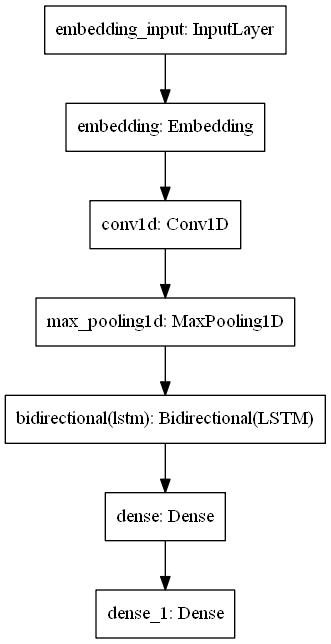

In [49]:
tf.keras.utils.plot_model(
    model,
    to_file="CNN+BiLSTM.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

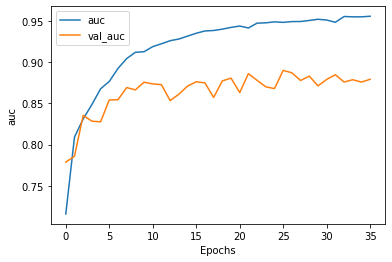

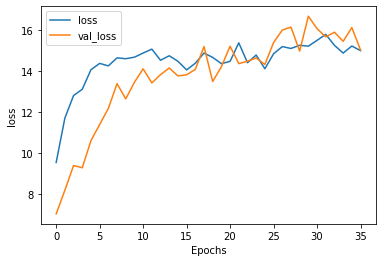

In [50]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc")
plot_graphs(history, "loss")

In [51]:
#score = model.evaluate(valid_padded, validation_labels)
#print("Loss = {}".format(score[0]))
#print("Accuracy = {0:.2f}%".format(score[1]*100))
#print(score)

In [52]:
y_pred = model.predict_classes(valid_padded)

accuracy = accuracy_score(valid_label, y_pred)
precision = precision_score(valid_label, y_pred, average='macro')
recall = recall_score(valid_label, y_pred, average='macro')
f1 = f1_score(valid_label, y_pred, average='macro')

print("Accuracy = {0:.2f}".format(accuracy*100))
print("Precision = {0:.4f}".format(precision))
print("Recall = {0:.4f}".format(recall))
print("F1-score = {0:.4f}".format(f1))

C:\Users\phvpa\anaconda3\envs\NLP\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy = 64.78
Precision = 0.5854
Recall = 0.6432
F1-score = 0.6077


In [53]:
confusion_matrix(valid_label,y_pred)

array([[ 51,  14,  19,   2,  16],
       [ 11, 140,  38,   6,  42],
       [ 42,  60, 474,  34,  96],
       [  3,   2,  10, 117,   9],
       [ 20,  59,  98,  41, 362]], dtype=int64)

In [54]:
print(classification_report(valid_label,y_pred))

              precision    recall  f1-score   support

           0       0.40      0.50      0.45       102
           1       0.51      0.59      0.55       237
           2       0.74      0.67      0.70       706
           3       0.58      0.83      0.69       141
           4       0.69      0.62      0.66       580

    accuracy                           0.65      1766
   macro avg       0.59      0.64      0.61      1766
weighted avg       0.66      0.65      0.65      1766



In [55]:
# Write some new reviews 

review1 = "ഈ കിളവന് നിർത്താറായില്ലേ കല്യാണം കഴിക്കാൻ നടക്കൽ..."
review2 = "I like mohanlal sirrr love from tamilnaduu"
review3 = "From tamilnadu mamukka fan vera level"

review1 = preprocess_data(review1)
review2 = preprocess_data(review2)
review3 = preprocess_data(review3)

new_reviews = [review1, review2, review3]
print(new_reviews)

['ഈ കിളവന് നിർത്താറായില്ലേ കല്യാണം കഴിക്കാൻ നടക്കൽ', 'i like mohanlal sirrr love from tamilnaduu', 'from tamilnadu mamukka fan vera level']


In [56]:
# Define a function to prepare the new reviews for use with a model
# and then use the model to predict the sentiment of the new reviews           

def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = tf.keras.preprocessing.sequence.pad_sequences(sample_sequences, padding=padding_type, 
                                 maxlen=max_length) 
  classes = model.predict_classes(reviews_padded)
  classes_prob = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(le.inverse_transform([classes[x]]))
    print(classes_prob[x])
    print('\n')

predict_review(model, new_reviews)

ഈ കിളവന് നിർത്താറായില്ലേ കല്യാണം കഴിക്കാൻ നടക്കൽ
['Negative']
[0.01594646 0.66461456 0.08111114 0.0016605  0.23666741]


i like mohanlal sirrr love from tamilnaduu
['not-malayalam']
[1.29203964e-03 1.83147276e-04 3.84297892e-02 9.48905110e-01
 1.11899385e-02]


from tamilnadu mamukka fan vera level
['not-malayalam']
[1.1804958e-02 8.4163033e-04 5.4222040e-02 9.2263848e-01 1.0492915e-02]




C:\Users\phvpa\anaconda3\envs\NLP\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [57]:
sample_test = test_text[0:10]
sample_test

['teaserinu kurach samayamkoodi mathram cant wait',
 'അപ്പോൾ കഥയുടെ  റൂട്ട് മാറിയല്ലോ',
 'മൂത്തോൻ ട്രൈലെർ trending list വരാത്തത് എന്താ ',
 'nowadays 944k views is considered as 1m views in kerala',
 'maasstrailer ennu paranja ithaanu makkalekatta waiting for ',
 'ethu kandappol kgf orma vannathu enikku matram ano ',
 'vere level  onnum parayan ella',
 'idvere vere chilar parannadaaannn muruga nee theernnada ennn ini nangal mammookka fans sherikkum parayunnnu murugaaa nee theernnada ikka love',
 'റിലീസ് ചെയ്ത അന്ന് തന്നെ പടം കാണാൻ ബോണി പറഞ്ഞു',
 'lalettanu thulayam malayalam film industry yil latten mathram']

In [58]:
predict_review(model, sample_test)

teaserinu kurach samayamkoodi mathram cant wait
['unknown_state']
[0.11708844 0.227251   0.11537006 0.08124889 0.4590416 ]


അപ്പോൾ കഥയുടെ  റൂട്ട് മാറിയല്ലോ
['unknown_state']
[3.3864155e-04 1.5062034e-04 2.2315781e-01 2.8298588e-02 7.4805433e-01]


മൂത്തോൻ ട്രൈലെർ trending list വരാത്തത് എന്താ 
['unknown_state']
[0.00199043 0.21090676 0.18582503 0.00429021 0.5969876 ]


nowadays 944k views is considered as 1m views in kerala
['not-malayalam']
[0.0028579  0.00922796 0.00153703 0.96793044 0.01844659]


maasstrailer ennu paranja ithaanu makkalekatta waiting for 
['Positive']
[4.0985006e-04 2.6466176e-04 9.8256207e-01 1.0413058e-03 1.5722027e-02]


ethu kandappol kgf orma vannathu enikku matram ano 
['unknown_state']
[2.3914145e-01 2.1434713e-02 1.2813106e-01 1.2989885e-04 6.1116290e-01]


vere level  onnum parayan ella
['Positive']
[0.19363463 0.03477546 0.70971745 0.00128691 0.0605856 ]


idvere vere chilar parannadaaannn muruga nee theernnada ennn ini nangal mammookka fans sherikkum para

In [59]:
classes = model.predict_classes(test_padded)
pred = []

for i in range(len(classes)):
  pred.append(le.inverse_transform([classes[i]])[0])

In [60]:
#pred[:]

In [61]:
pred_df = pd.DataFrame(pred, columns=['label'])
pred_df.head()

,label
0,unknown_state
1,unknown_state
2,unknown_state
3,not-malayalam
4,Positive


In [62]:
result = pd.concat([test_df, pred_df], axis=1)
result.head()

,id,text,label
0,Mal_1,teaserinu kurach samayamkoodi mathram cant wait,unknown_state
1,Mal_2,അപ്പോൾ കഥയുടെ റൂട്ട് മാറിയല്ലോ,unknown_state
2,Mal_3,മൂത്തോൻ ട്രൈലെർ trending list വരാത്തത് എന്താ,unknown_state
3,Mal_4,nowadays 944k views is considered as 1m views ...,not-malayalam
4,Mal_5,maasstrailer ennu paranja ithaanu makkalekatta...,Positive


In [63]:
result.to_csv('CNN+LSTM_Malyalam_Test_Pred_Labels_19-06-2021.csv', sep = '\t', index=False)

In [64]:
Valid_classes = model.predict_classes(valid_padded)
Valid_pred = []

for i in range(len(Valid_classes)):
    Valid_pred.append(le.inverse_transform([Valid_classes[i]])[0])

C:\Users\phvpa\anaconda3\envs\NLP\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [65]:
Valid_classes.shape

(1766,)

In [66]:
Valid_pred_df = pd.DataFrame(Valid_pred, columns=['Predicted label'])
Valid_pred_df.head()

,Predicted label
0,Positive
1,not-malayalam
2,Positive
3,unknown_state
4,Positive


In [67]:
Valid_result = pd.concat([valid_df, Valid_pred_df], axis=1)
Valid_result

,text,category,Predicted label
0,mammooka ninghal mass aa pwoli item,Positive,Positive
1,waiting for malayalam movie for tamil paiyan,not-malayalam,not-malayalam
2,ദളപതി ഫാൻസിന്റെ വക ഒരു ഒന്നൊന്നര വിജയാശംസകൾ,Positive,Positive
3,pwolichuuuu ഓണത്തിന് വന്നങ്ങു തകർത്തേക്ക്,Positive,unknown_state
4,mammoookkaaaa polichadukkiii katta waiting nv 21,Positive,Positive
...,...,...,...
1761,aa ചിരി uff എന്റെ പൊന്നോ ഇക്ക vere ലെവൽ,Positive,Positive
1762,katta katta katta katta waitingcant wait man,Positive,Positive
1763,arjun reddy bgm poole thonniyathu enniku mathr...,unknown_state,unknown_state
1764,fahad ikka ithilum polikum en urappayi,Positive,Positive


In [68]:
Valid_result.to_csv('CNN+LSTM_Malyalam_Valid_Pred_Labels_19-06-2021.csv', sep = '\t', index=False)

In [69]:
valid_df

,text,category
0,mammooka ninghal mass aa pwoli item,Positive
1,waiting for malayalam movie for tamil paiyan,not-malayalam
2,ദളപതി ഫാൻസിന്റെ വക ഒരു ഒന്നൊന്നര വിജയാശംസകൾ,Positive
3,pwolichuuuu ഓണത്തിന് വന്നങ്ങു തകർത്തേക്ക്,Positive
4,mammoookkaaaa polichadukkiii katta waiting nv 21,Positive
...,...,...
1761,aa ചിരി uff എന്റെ പൊന്നോ ഇക്ക vere ലെവൽ,Positive
1762,katta katta katta katta waitingcant wait man,Positive
1763,arjun reddy bgm poole thonniyathu enniku mathr...,unknown_state
1764,fahad ikka ithilum polikum en urappayi,Positive


In [71]:
d = pd.read_csv("CNN+LSTM_Malyalam_Valid_Pred_Labels_19-06-2021.csv", sep='\t')
d

,text,category,Predicted label
0,mammooka ninghal mass aa pwoli item,Positive,Positive
1,waiting for malayalam movie for tamil paiyan,not-malayalam,not-malayalam
2,ദളപതി ഫാൻസിന്റെ വക ഒരു ഒന്നൊന്നര വിജയാശംസകൾ,Positive,Positive
3,pwolichuuuu ഓണത്തിന് വന്നങ്ങു തകർത്തേക്ക്,Positive,unknown_state
4,mammoookkaaaa polichadukkiii katta waiting nv 21,Positive,Positive
...,...,...,...
1761,aa ചിരി uff എന്റെ പൊന്നോ ഇക്ക vere ലെവൽ,Positive,Positive
1762,katta katta katta katta waitingcant wait man,Positive,Positive
1763,arjun reddy bgm poole thonniyathu enniku mathr...,unknown_state,unknown_state
1764,fahad ikka ithilum polikum en urappayi,Positive,Positive


In [72]:
d1 = pd.read_csv("CNN+LSTM_Malyalam_Test_Pred_Labels_19-06-2021.csv", sep='\t')
d1

,id,text,label
0,Mal_1,teaserinu kurach samayamkoodi mathram cant wait,unknown_state
1,Mal_2,അപ്പോൾ കഥയുടെ റൂട്ട് മാറിയല്ലോ,unknown_state
2,Mal_3,മൂത്തോൻ ട്രൈലെർ trending list വരാത്തത് എന്താ,unknown_state
3,Mal_4,nowadays 944k views is considered as 1m views ...,not-malayalam
4,Mal_5,maasstrailer ennu paranja ithaanu makkalekatta...,Positive
...,...,...,...
1957,Mal_1958,expression വച്ചു നോക്കുമ്പോൾ മൂക്കുത്തി കട്ടത്...,Positive
1958,Mal_1959,എനിക്ക് ഒരു 100 like തരുമോ,unknown_state
1959,Mal_1960,nannayi onnu poliyunna lakshnm undethrill main...,unknown_state
1960,Mal_1961,athikam eduthu kayatti vekkendadirection kke k...,unknown_state
